In [1]:
from IPython.display import display, Image
from pprint import pprint
from itertools import chain
from sympy.solvers.pde import pdsolve
from sympy import Function, Symbol, symbols

from ginv import *
sympy.init_printing()

Условие интегрируемости (совместности) данной системы можно записать через $S$-полином (лексикографическое упорядочение $t \succ x \succ y$)
\begin{equation}
\big(\mathbf{u_{tx}} + \alpha u_{xx} + \beta u_{xx} u_{x}^2 + \gamma u_{yy}
 + \delta u
)_\varepsilon 
- \mathbf{u_{\varepsilon tx}} + \frac{d^2}{dtdx}F = 0
\end{equation}

В последнем уравнении в силу правила дифференцирования Лейбница производная по $\varepsilon $
входит в условие интрегриемости линейно. 
\begin{equation}
\alpha u_{\varepsilon xx} + 2\beta u_{xx} u_{\varepsilon x}u_{x}  + \beta u_{\varepsilon xx} u_{x}^2 + \gamma u_{\varepsilon yy}
 + \delta u_{\varepsilon} + \frac{d^2}{dtdx}F = 0
\end{equation}
При этом мы можем заменить $u_{\varepsilon }$ на $F$ используя полные производные от $F$.
\begin{equation}
\alpha \frac{d^2}{dx^2}F + 2\beta u_{xx}u_{x}\frac{d}{dx}F
 + \beta u_{x}^2\frac{d^2}{dx^2}F  + \gamma\frac{d^2}{dy^2}F + \delta F
+ \frac{d^2}{dtdx}F = 0
\end{equation}

Учитывая в силу самого уравнения
\begin{equation}
\begin{aligned}
u_{tx} &= - \alpha u_{xx} - \beta u_{xx} u_{x} - \gamma u_{yy} \\
u_{ttx} &= - \alpha u_{txx} -  \beta u_{txx} u_{x} -  \beta u_{xx} (- \alpha u_{xx} - \beta u_{xx} u_{x} - \gamma u_{yy}) - \gamma u_{tyy}  \\
u_{txx} &= - \alpha u_{xxx} -  \beta u_{xxx} u_{x} -  \beta u_{xxx} u_{xx} - \gamma u_{xyy}  \\
u_{txy} &= - \alpha u_{xxy}  -  \beta u_{xxy} u_{x} -  \beta u_{xxx} u_{xy} - \gamma u_{yyy}  \\
& \cdots \\
\end{aligned}
\end{equation}
и то что само $F$ не зависит от производных выше первого порядка $u_{t}, u_{x}, u_{y}$ можно получить 
систему линейных уравнений на $F$.

In [2]:
a, b, g, dl = symbols('alpha, beta, gamma, delta')
eps, t, x, y = symbols('ε, t, x, y')
U = Function('U')(eps, t, x, y)

a, b, g, dl = a, 1, 1, dl

u, ut, ux, uy = symbols('u, u_t, u_x, u_y', real=True)
F = Function('F')(t, x, y, u, ut, ux, uy)

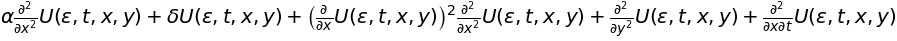

In [3]:
eq1 = U.diff(t, x) + a*U.diff(x, 2) + b*U.diff(x)**2*U.diff(x, 2) + g*U.diff(y, 2) + dl*U
eq1

In [4]:
dct = {U: "u", F: "F"}
def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in dct:
                return sympy.Symbol(dct[a], real=True)
            elif a.func == sympy.Derivative:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, sympy.Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return sympy.Symbol(f"{dct[a.args[0]]}_{{{''.join(m)}}}", real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return cmpct(f)

In [5]:
compact(eq1)

In [6]:
compact(eq1.diff(eps))

In [7]:
def Dt(a):
    return a.diff(t) + a.diff(u)*ut + a.diff(ut)*U.diff(t, t)\
         + a.diff(ux)*U.diff(x, t) + a.diff(uy)*U.diff(y, t)
def Dx(a):
    return a.diff(x) + a.diff(u)*ux + a.diff(ut)*U.diff(t, x)\
         + a.diff(ux)*U.diff(x, x) + a.diff(uy)*U.diff(y, x)
def Dy(a):
    return a.diff(y) + a.diff(u)*uy + a.diff(ut)*U.diff(t, y)\
         + a.diff(ux)*U.diff(x, y) + a.diff(uy)*U.diff(y, y)

In [8]:
toD = {
    t: Dt,\
    x: Dx,\
    y: Dy,\
}
def totalD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(totalD(s) for s in a.args))
        elif (eps, 1) not in a.args:
            return a
        else:
            assert a.args[0] == U
            r = F
            for v, l in a.args[1:]:
                if v != eps:
                    for i in range(l):
                        r = toD[v](r)
            return r
eq2 = totalD(eq1.diff(eps)).expand()     

In [9]:
compact(eq2)

In [10]:
print(sympy.latex(compact(eq2)))

F \delta + F_{tu_t} u_{tx} + F_{tu_x} u_{xx} + F_{tu_y} u_{xy} + F_{tu} u_{x} + F_{tx} + F_{u_tu_t} \alpha u_{tx}^{2} + F_{u_tu_t} u_{tt} u_{tx} + F_{u_tu_t} u_{tx}^{2} u_{x}^{2} + F_{u_tu_t} u_{ty}^{2} + 2 F_{u_tu_x} \alpha u_{tx} u_{xx} + F_{u_tu_x} u_{tt} u_{xx} + F_{u_tu_x} u_{tx}^{2} + 2 F_{u_tu_x} u_{tx} u_{xx} u_{x}^{2} + 2 F_{u_tu_x} u_{ty} u_{xy} + 2 F_{u_tu_y} \alpha u_{tx} u_{xy} + F_{u_tu_y} u_{tt} u_{xy} + F_{u_tu_y} u_{tx} u_{ty} + 2 F_{u_tu_y} u_{tx} u_{xy} u_{x}^{2} + 2 F_{u_tu_y} u_{ty} u_{yy} + 2 F_{u_tx} \alpha u_{tx} + F_{u_tx} u_{tt} + 2 F_{u_tx} u_{tx} u_{x}^{2} + 2 F_{u_ty} u_{ty} + F_{u_t} \alpha u_{txx} + F_{u_t} u_{ttx} + F_{u_t} u_{txx} u_{x}^{2} + 2 F_{u_t} u_{tx} u_{xx} u_{x} + F_{u_t} u_{tyy} + F_{u_xu_x} \alpha u_{xx}^{2} + F_{u_xu_x} u_{tx} u_{xx} + F_{u_xu_x} u_{xx}^{2} u_{x}^{2} + F_{u_xu_x} u_{xy}^{2} + 2 F_{u_xu_y} \alpha u_{xx} u_{xy} + F_{u_xu_y} u_{tx} u_{xy} + F_{u_xu_y} u_{ty} u_{xx} + 2 F_{u_xu_y} u_{xx} u_{xy} u_{x}^{2} + 2 F_{u_xu_y} u_{xy} u

In [11]:
s = sympy.solve(eq1, U.diff(t, x))[0]
def sub_eq(a):
    def find(args):
        r = 0
        for v, l in a.args[1:]:
            if v in (t, x):
                r += 1
        return r >= 2
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(sub_eq(s) for s in a.args))
        elif a.args[0] != U or not find(a.args):
            return a
        else:
            r = s
            for v, l in a.args[1:]:
                if v in (t, x):
                    l -= 1
                r = r.diff(v, l)
            return r
eq3 = sub_eq(eq2).expand()
eq3 = sub_eq(eq3).expand()
eq3 = sub_eq(eq3).expand()

In [12]:
compact(eq3)

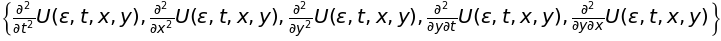

In [13]:
toU = {
    U.diff(t): ut,\
    U.diff(x): ux,\
    U.diff(y): uy,\
}
DF = set()
def lstD(a):
    if not a.args:
        return a
    else:
        if a.func != sympy.Derivative:
            return a.func(*(lstD(s) for s in a.args))
        elif a.args[0] != U:
            return a
        elif a in toU:
            return toU[a]
        else:
            DF.add(a)
            return a
eq4 = lstD(eq3).expand()
DF

In [14]:
[compact(df) for df in DF]

In [15]:
def to_eqs(a, var):
    for x in var:
        r = []
        for b in a:
            if b:
                r.append([b.coeff(x, i) for i in range(b.as_poly(x).degree()+1) if b.coeff(x, i)])
        a = chain(*r)
    return list(a)

eqs = to_eqs([eq4], DF)
for eq in eqs:
    print(sympy.latex(compact(eq)) + r" = 0, \\")
[compact(eq) for eq in eqs]

F \delta - F_{tu_t} \delta u + F_{tu} u_{x} + F_{tx} + F_{u_tu_t} \alpha \delta^{2} u^{2} + F_{u_tu_t} \delta^{2} u^{2} u_{x}^{2} + F_{u_tu_x} \delta^{2} u^{2} - 2 F_{u_tx} \alpha \delta u - 2 F_{u_tx} \delta u u_{x}^{2} - F_{u_t} \delta u_{t} - F_{u_xx} \delta u - F_{u_x} \delta u_{x} - F_{u_y} \delta u_{y} - 2 F_{uu_t} \alpha \delta u u_{x} - F_{uu_t} \delta u u_{t} - 2 F_{uu_t} \delta u u_{x}^{3} - F_{uu_x} \delta u u_{x} + F_{uu} \alpha u_{x}^{2} + F_{uu} u_{t} u_{x} + F_{uu} u_{x}^{4} + F_{uu} u_{y}^{2} + 2 F_{ux} \alpha u_{x} + F_{ux} u_{t} + 2 F_{ux} u_{x}^{3} + 2 F_{uy} u_{y} - F_{u} \delta u + F_{xx} \alpha + F_{xx} u_{x}^{2} + F_{yy} = 0, \\
F_{tu_y} - 2 F_{u_tu_y} \alpha \delta u - 2 F_{u_tu_y} \delta u u_{x}^{2} - F_{u_xu_y} \delta u + 2 F_{u_xy} + 2 F_{u_yx} \alpha + 2 F_{u_yx} u_{x}^{2} + 2 F_{uu_x} u_{y} + 2 F_{uu_y} \alpha u_{x} + F_{uu_y} u_{t} + 2 F_{uu_y} u_{x}^{3} = 0, \\
F_{u_xu_x} + F_{u_yu_y} \alpha + F_{u_yu_y} u_{x}^{2} = 0, \\
- F_{tu_t} \alpha - F_{tu_t} u_{x

In [16]:
if a or dl:
    for k in [ut, ux, uy, t*uy - ux*y/2, a*t*ux + t*ut/2 + u - ux*x/2]:
        for eq in eqs:
            print(eq.subs({F: k, U: u}).doit().expand(), end=" ")
        print()
else:
    for k in [ut, ux, -2*t*uy + ux*y, uy, 3*t*ut/2 + ux*x/2 + uy*y, t*ut/2 + u - ux*x/2]:
        for eq in eqs:
            print(eq.subs({F: k, U: u}).doit().expand(), end=" ")
        print()

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


In [17]:
Monom.cmp = Monom.TOPdeglex

In [18]:
var = ['t', 'x', 'y', 'u', 'u_t', 'u_x', 'u_y']
fun = ['F']
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, y, u, ut, ux, uy = var
F = fun[0]

In [19]:
compact(eqs[0].subs({U: u}))

In [20]:
diff2poly(eqs[0].subs({U: u}))

[[[0;1 1 0 0 0 0 0], 1],
 [[0;0 2 0 0 0 0 0], alpha + u_x**2],
 [[0;0 0 2 0 0 0 0], 1],
 [[0;1 0 0 1 0 0 0], u_x],
 [[0;0 1 0 1 0 0 0], 2*alpha*u_x + u_t + 2*u_x**3],
 [[0;0 0 1 1 0 0 0], 2*u_y],
 [[0;0 0 0 2 0 0 0], alpha*u_x**2 + u_t*u_x + u_x**4 + u_y**2],
 [[0;1 0 0 0 1 0 0], -delta*u],
 [[0;0 1 0 0 1 0 0], -2*alpha*delta*u - 2*delta*u*u_x**2],
 [[0;0 0 0 1 1 0 0], -2*alpha*delta*u*u_x - delta*u*u_t - 2*delta*u*u_x**3],
 [[0;0 0 0 0 2 0 0], alpha*delta**2*u**2 + delta**2*u**2*u_x**2],
 [[0;0 1 0 0 0 1 0], -delta*u],
 [[0;0 0 0 1 0 1 0], -delta*u*u_x],
 [[0;0 0 0 0 1 1 0], delta**2*u**2],
 [[0;0 0 0 1 0 0 0], -delta*u],
 [[0;0 0 0 0 1 0 0], -delta*u_t],
 [[0;0 0 0 0 0 1 0], -delta*u_x],
 [[0;0 0 0 0 0 0 1], -delta*u_y],
 [[0;0 0 0 0 0 0 0], delta]]

In [21]:
print(diff2poly(eqs[0].subs({U: u})))

df(F, t, x) + df(F, x, 2)*(alpha + u_x**2) + df(F, y, 2) + df(F, t, u)*u_x + df(F, x, u)*(2*alpha*u_x + u_t + 2*u_x**3) + df(F, y, u)*2*u_y + df(F, u, 2)*(alpha*u_x**2 + u_t*u_x + u_x**4 + u_y**2) + df(F, t, u_t)*(-delta*u) + df(F, x, u_t)*(-2*alpha*delta*u - 2*delta*u*u_x**2) + df(F, u, u_t)*(-2*alpha*delta*u*u_x - delta*u*u_t - 2*delta*u*u_x**3) + df(F, u_t, 2)*(alpha*delta**2*u**2 + delta**2*u**2*u_x**2) + df(F, x, u_x)*(-delta*u) + df(F, u, u_x)*(-delta*u*u_x) + df(F, u_t, u_x)*delta**2*u**2 + df(F, u)*(-delta*u) + df(F, u_t)*(-delta*u_t) + df(F, u_x)*(-delta*u_x) + df(F, u_y)*(-delta*u_y) + df(F)*delta


In [22]:
LRT = Janet()
res = ginvBlockLow([diff2poly(eq.subs({U: u})) for eq in eqs], \
LRT, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT.count()}")
print(f"reduction: {LRT.reduction()}")
print(f"       HP: {LRT.HP()}")
LRT.saveImage('LRT.pdf', level=1)

prolong 0, Q 2
df(F, u_t, u_y)
prolong 0, Q 2
df(F, u_x, u_y), df(F, u_x, 2), df(F, u_t, u_x), df(F, y, u_x), df(F, u_t, 2), df(F, u_y, 2), df(F, y, u_t), df(F, x, u_t), df(F, t, u_t), df(F, t, u_x), df(F, t, x)
prolong 2, Q 0
df(F, y, u_y, 2)
prolong 3, Q 3
df(F, x, u_y, 2)
prolong 3, Q 3
df(F, t, u_y, 2)
prolong 3, Q 3
df(F, u, u_x)
prolong 2, Q 3
df(F, u, u_y, 2)
prolong 3, Q 3
df(F, x, u_x, u_y)
prolong 3, Q 3
df(F, x, u_y)
prolong 2, Q 3
df(F, u, u_y)
prolong 2, Q 3
df(F, u, u_t)
prolong 2, Q 3
df(F, y, u, u_y)
prolong 2, Q 3
df(F, t, u, u_y)
prolong 2, Q 3
df(F, x, u_x), df(F, x, u), df(F, y, u)
prolong 2, Q 3
df(F, u, 2)
prolong 2, Q 3
df(F, y, 2, u_y)
prolong 2, Q 3
df(F, t, y, u_y)
prolong 2, Q 3
df(F, t, 2, u_y)
prolong 2, Q 3
df(F, y, u_y)
prolong 2, Q 3
df(F, x, y)
prolong 2, Q 3
df(F, x, 2)
prolong 2, Q 3
df(F, y, 2)
prolong 2, Q 3
df(F, t, u, u_x)
prolong 3, Q 3
df(F, t, u)
prolong 2, Q 3
df(F, t, y, u_x)
prolong 3, Q 3
df(F, t, 2, u_x)
prolong 3, Q 3
df(F, t, y, u_t)
pro

In [23]:
for w in LRT.GB():
    print(w.poly)

df(F, u_y, 2)
df(F, u_x, u_y)
df(F, u_x, 2)
df(F, u_t, u_y)
df(F, u_t, u_x)
df(F, u_t, 2)
df(F, u, u_y)
df(F, u, u_x)
df(F, u, u_t)
df(F, u, 2)
df(F, y, u_y)
df(F, y, u_x)*(-2) + df(F, t, u_y)*(-1)
df(F, y, u_t)
df(F, y, u)
df(F, y, 2) + df(F, u)*(-delta*u) + df(F, u_t)*(-delta*u_t) + df(F, u_x)*(-delta*u_x) + df(F, u_y)*(-delta*u_y) + df(F)*delta
df(F, x)*2 + df(F, u)*u_x
df(F, t, u_x) + df(F, u)*(-alpha)
df(F, t, u_t)*2 + df(F, u)*(-1)
df(F, t, u)
df(F, t, y, u_y)
df(F, t, x)
df(F, t, 2, u_y)


In [24]:
for w in LRT.GB():
    print(" + ".join([f"{{{sympy.latex(c)}}}{m.df_latex()}" for m, c in w.poly]) + r" = 0, \\")

{1}{F}_{{u_y} {u_y}} = 0, \\
{1}{F}_{{u_x} {u_y}} = 0, \\
{1}{F}_{{u_x} {u_x}} = 0, \\
{1}{F}_{{u_t} {u_y}} = 0, \\
{1}{F}_{{u_t} {u_x}} = 0, \\
{1}{F}_{{u_t} {u_t}} = 0, \\
{1}{F}_{{u} {u_y}} = 0, \\
{1}{F}_{{u} {u_x}} = 0, \\
{1}{F}_{{u} {u_t}} = 0, \\
{1}{F}_{{u} {u}} = 0, \\
{1}{F}_{{y} {u_y}} = 0, \\
{-2}{F}_{{y} {u_x}} + {-1}{F}_{{t} {u_y}} = 0, \\
{1}{F}_{{y} {u_t}} = 0, \\
{1}{F}_{{y} {u}} = 0, \\
{1}{F}_{{y} {y}} + {- \delta u}{F}_{{u}} + {- \delta u_{t}}{F}_{{u_t}} + {- \delta u_{x}}{F}_{{u_x}} + {- \delta u_{y}}{F}_{{u_y}} + {\delta}{F} = 0, \\
{2}{F}_{{x}} + {u_{x}}{F}_{{u}} = 0, \\
{1}{F}_{{t} {u_x}} + {- \alpha}{F}_{{u}} = 0, \\
{2}{F}_{{t} {u_t}} + {-1}{F}_{{u}} = 0, \\
{1}{F}_{{t} {u}} = 0, \\
{1}{F}_{{t} {y} {u_y}} = 0, \\
{1}{F}_{{t} {x}} = 0, \\
{1}{F}_{{t} {t} {u_y}} = 0, \\


In [25]:
T = sum(sympy.Function(i)(t, x, y)*j for i, j in zip(\
    ('A', 'B', 'C', 'D', 'E'),
    (ut, ux, uy, u, 1)))
T

In [26]:
var

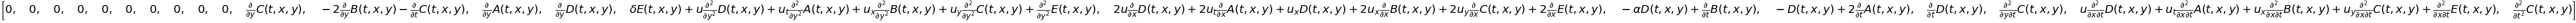

In [27]:
eqs1 = []
for w in LRT.GB():
    eqs1.append(sum(T.diff(*((v, d) for v, d in zip(var, m)))*c for m, c in w.poly).expand())
eqs1

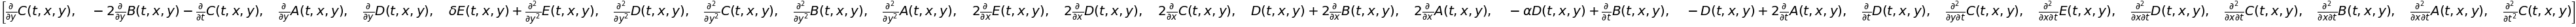

In [28]:
eqs2 = to_eqs(eqs1, [ut, ux, uy, u])
eqs2

In [29]:
dct = dict((Function(i)(t, x, y), i) for i in ('A', 'B', 'C', 'D', 'E'))
for eq in eqs2:
    print(sympy.latex(compact(eq)) + r" = 0, \\")

C_{y} = 0, \\
- 2 B_{y} - C_{t} = 0, \\
A_{y} = 0, \\
D_{y} = 0, \\
E \delta + E_{yy} = 0, \\
D_{yy} = 0, \\
C_{yy} = 0, \\
B_{yy} = 0, \\
A_{yy} = 0, \\
2 E_{x} = 0, \\
2 D_{x} = 0, \\
2 C_{x} = 0, \\
2 B_{x} + D = 0, \\
2 A_{x} = 0, \\
B_{t} - D \alpha = 0, \\
2 A_{t} - D = 0, \\
D_{t} = 0, \\
C_{ty} = 0, \\
E_{tx} = 0, \\
D_{tx} = 0, \\
C_{tx} = 0, \\
B_{tx} = 0, \\
A_{tx} = 0, \\
C_{tt} = 0, \\


In [30]:
var = ['t', 'x', 'y']
fun = ['A', 'B', 'C', 'D', 'E']
Monom.init(var, fun)
df = PolyDiff.df
diff2poly = PolyDiff.diff2poly
var, fun = PolyDiff.init()
t, x, y = var
A, B, C, D, E = fun

LRT1 = Forest(Janet)
res = ginvBlockLow([diff2poly(eq) for eq in eqs2 if eq], \
LRT1, level=1)
print(f"    crit1: {res[1]}")
print(f"    crit2: {res[2]}")
print(f"     time: {res[0]:.2f} sec")
print(f"    count: {LRT1.count()}")
print(f"reduction: {LRT1.reduction()}")
print(f"       HP: {LRT1.HP()}")

prolong 0, Q 1
df(A, y)
prolong 0, Q 1
df(C, y)
prolong 0, Q 1
df(D, y)
prolong 0, Q 1
df(A, x)
prolong 0, Q 1
df(B, x)
prolong 0, Q 1
df(C, x)
prolong 0, Q 1
df(D, x)
prolong 0, Q 1
df(E, x)
prolong 0, Q 1
df(A, t)
prolong 0, Q 1
df(B, t)
prolong 0, Q 1
df(C, t)
prolong 0, Q 1
df(D, t)
prolong 0, Q 2
df(B, y, 2)
prolong 0, Q 2
df(E, y, 2)
prolong 1, Q 2
prolong 2, Q 0
prolong 0, Q 0
    crit1: 0
    crit2: 0
     time: 0.04 sec
    count: 14
reduction: 63
       HP: 2s + 6


In [31]:
for w in LRT1.GB():
    print(w.poly)

df(A, y)
df(A, x)
df(A, t)*2 + df(D)*(-1)
df(B, y, 2)
df(B, x)*2 + df(D)
df(B, t) + df(D)*(-alpha)
df(C, y)
df(C, x)
df(C, t)*(-1) + df(B, y)*(-2)
df(D, y)
df(D, x)
df(D, t)
df(E, y, 2) + df(E)*delta
df(E, x)


In [32]:
for w in LRT1.GB():
    print(" + ".join([f"{{{sympy.latex(c)}}}{m.df_latex()}" for m, c in w.poly]) + r" = 0, \\")

{1}{A}_{{y}} = 0, \\
{1}{A}_{{x}} = 0, \\
{2}{A}_{{t}} + {-1}{D} = 0, \\
{1}{B}_{{y} {y}} = 0, \\
{2}{B}_{{x}} + {1}{D} = 0, \\
{1}{B}_{{t}} + {- \alpha}{D} = 0, \\
{1}{C}_{{y}} = 0, \\
{1}{C}_{{x}} = 0, \\
{-1}{C}_{{t}} + {-2}{B}_{{y}} = 0, \\
{1}{D}_{{y}} = 0, \\
{1}{D}_{{x}} = 0, \\
{1}{D}_{{t}} = 0, \\
{1}{E}_{{y} {y}} + {\delta}{E} = 0, \\
{1}{E}_{{x}} = 0, \\


In [33]:
for f in fun:
    for v in var:
        for i in range(3):
            if not df(f, v, i).NF(LRT1):
                print(df(f, v, i))
                break

df(A, t, 2)
df(A, x)
df(A, y)
df(B, t, 2)
df(B, x, 2)
df(B, y, 2)
df(C, t, 2)
df(C, x)
df(C, y)
df(D, t)
df(D, x)
df(D, y)
df(E, x)


In [34]:
T1 = [\
sympy.Symbol('A0') + sympy.Symbol('A1')*t, 
sympy.Symbol('B0') + sympy.Symbol('B1')*t + sympy.Symbol('B2')*x + sympy.Symbol('B3')*y\
      + sympy.Symbol('B4')*t*x + sympy.Symbol('B5')*t*y + sympy.Symbol('B6')*x*y,
sympy.Symbol('C0') + sympy.Symbol('C1')*t + sympy.Symbol('C2')*y + sympy.Symbol('C3')*t*y,
sympy.Symbol('D0'),
sympy.Function('E0')(t, y) if dl else sympy.Function('E0')(t) + sympy.Function('E0')(t)*y]
T1

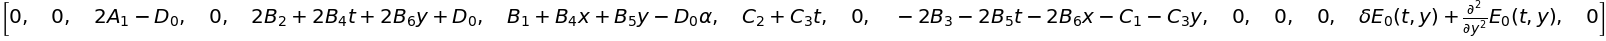

In [35]:
eqs3 = []
for w in LRT1.GB():
    eqs3.append(sum(T1[m.position()].diff(*((v, d) for v, d in zip(var, m)))*c for m, c in w.poly).expand())
eqs3

In [36]:
eqs4 = to_eqs(eqs3[:-2], [t, x, y])
eqs4

In [37]:
if a:
    s4 = sympy.solve(eqs4)[0]
else:
    s4 = sympy.solve(eqs4)
s4

In [38]:
T2 = [eq.subs(s4).expand() for eq in T1]
T2

In [39]:
T3 = ut*T2[0] + ux*T2[1] + uy*T2[2] + u*T2[3] + T2[4]
T3 = T3.expand()
T3 

In [40]:
print(sympy.latex(T3))

A_{0} u_{t} + B_{0} u_{x} + C_{0} u_{y} + C_{1} t u_{y} - \frac{C_{1} u_{x} y}{2} + D_{0} \alpha t u_{x} + \frac{D_{0} t u_{t}}{2} + D_{0} u - \frac{D_{0} u_{x} x}{2} + \operatorname{E_{0}}{\left (t,y \right )}


In [41]:
if a or dl:
    T4 = [T3.coeff(v) for v in (Symbol(i) for i in 'A0, B0, C0, C1, D0'.split(", "))]
else:
    T4 = [T3.coeff(v) for v in (Symbol(i) for i in 'A0, B0, B3, C0, C2, D0'.split(", "))]
print(T4)
T4

[u_t, u_x, u_y, t*u_y - u_x*y/2, alpha*t*u_x + t*u_t/2 + u - u_x*x/2]


In [42]:
print(sympy.latex(T4))

\left [ u_{t}, \quad u_{x}, \quad u_{y}, \quad t u_{y} - \frac{u_{x} y}{2}, \quad \alpha t u_{x} + \frac{t u_{t}}{2} + u - \frac{u_{x} x}{2}\right ]


In [43]:
u = Function('u')(t, x)
eq = t*u.diff(t)/2 + u - u.diff(x)*x/2
eq

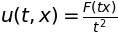

In [44]:
pdsolve(eq)

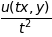

In [45]:
xi1 = Symbol('xi1')
u = Function('u')(t*x, y)/t**2
u

In [46]:
r = sympy.simplify(u.diff(t, x) + u.diff(x, 2)*u.diff(x)**2 + u.diff(y, 2) + dl*u)
r

                  ⎛  2           ⎞│           2                               
                  ⎜ ∂            ⎟│          ∂               ⎛ ∂           ⎞│ 
δ⋅u(t⋅x, y) + t⋅x⋅⎜────(u(ξ₁, y))⎟│       + ───(u(t⋅x, y)) + ⎜───(u(ξ₁, y))⎟│ 
                  ⎜   2          ⎟│           2              ⎝∂ξ₁          ⎠│ξ
                  ⎝∂ξ₁           ⎠│ξ₁=t⋅x   ∂y                                
──────────────────────────────────────────────────────────────────────────────
                                                                   2          
                                                                  t           

     2 ⎛  2           ⎞│                               
       ⎜ ∂            ⎟│         ⎛ ∂           ⎞│      
      ⋅⎜────(u(ξ₁, y))⎟│       - ⎜───(u(ξ₁, y))⎟│      
₁=t⋅x  ⎜   2          ⎟│         ⎝∂ξ₁          ⎠│ξ₁=t⋅x
       ⎝∂ξ₁           ⎠│ξ₁=t⋅x                         
───────────────────────────────────────────────────────
                               

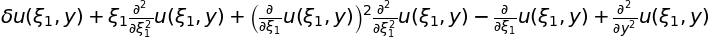

In [47]:
r.args[1].subs({t: xi1/x}).doit()

In [48]:
a = Symbol('alpha')
u = Function('u')(t, x)
eq = a*t*u.diff(x) + t*u.diff(t)/2 + u - u.diff(x)*x/2
eq

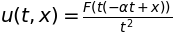

In [49]:
pdsolve(eq)

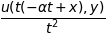

In [50]:
u = Function('u')(t*(-a*t + x), y)/t**2
u

In [51]:
r = sympy.simplify(u.diff(t, x) + a*u.diff(x, 2) + u.diff(x, 2)*u.diff(x)**2 + u.diff(y, 2) + dl*u)
r

       ⎛  2           ⎞│                                             ⎛  2     
     2 ⎜ ∂            ⎟│                                             ⎜ ∂      
- α⋅t ⋅⎜────(u(ξ₁, y))⎟│                + δ⋅u(t⋅(-α⋅t + x), y) + t⋅x⋅⎜────(u(ξ
       ⎜   2          ⎟│                                             ⎜   2    
       ⎝∂ξ₁           ⎠│ξ₁=t⋅(-α⋅t + x)                              ⎝∂ξ₁     
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

      ⎞│                    2                                                 
      ⎟│                   ∂                        ⎛ ∂           ⎞│          
₁, y))⎟│                + ───(u(t⋅(-α⋅t + x), y)) + ⎜───(u(ξ₁, y))⎟│          
      ⎟│                    2                       ⎝∂ξ₁          ⎠│ξ₁=t⋅(-α⋅t
      ⎠│ξ₁=t⋅(-α⋅t + x)   ∂y                       

In [52]:
r.args[1].doit().subs({t*x: xi1 + a*t**2}).simplify().doit()

                          ⎛  2           ⎞│                    2              
                          ⎜ ∂            ⎟│                   ∂               
δ⋅u(t⋅(-α⋅t + x), y) + ξ₁⋅⎜────(u(ξ₁, y))⎟│                + ───(u(-t⋅(α⋅t - x
                          ⎜   2          ⎟│                    2              
                          ⎝∂ξ₁           ⎠│ξ₁=t⋅(-α⋅t + x)   ∂y               

                                        2 ⎛  2           ⎞│                   
         ⎛ ∂           ⎞│                 ⎜ ∂            ⎟│                  ⎛
), y)) + ⎜───(u(ξ₁, y))⎟│                ⋅⎜────(u(ξ₁, y))⎟│                - ⎜
         ⎝∂ξ₁          ⎠│ξ₁=t⋅(-α⋅t + x)  ⎜   2          ⎟│                  ⎝
                                          ⎝∂ξ₁           ⎠│ξ₁=t⋅(-α⋅t + x)    

                              
 ∂           ⎞│               
───(u(ξ₁, y))⎟│               
∂ξ₁          ⎠│ξ₁=t⋅(-α⋅t + x)
                              

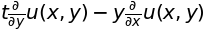

In [53]:
u = Function('u')(x, y)
eq = t*u.diff(y) - y*u.diff(x)
eq

In [54]:
pdsolve(eq)

In [55]:
u = Function('u')(t, 2*t*x + y**2)
u

In [56]:
r = sympy.simplify(u.diff(t, x) + u.diff(x, 2)*u.diff(x)**2 + u.diff(y, 2) + dl*u)
r

                                                        2 ⎛  2           ⎞│   
   ⎛            2⎞       4 ⎛ ∂           ⎞│               ⎜ ∂            ⎟│   
δ⋅u⎝t, 2⋅t⋅x + y ⎠ + 16⋅t ⋅⎜───(u(t, ξ₂))⎟│            2 ⋅⎜────(u(t, ξ₂))⎟│   
                           ⎝∂ξ₂          ⎠│ξ₂=2⋅t⋅x + y   ⎜   2          ⎟│   
                                                          ⎝∂ξ₂           ⎠│ξ₂=

                   ⎛  2           ⎞│                    ⎛   2            ⎞│   
                   ⎜ ∂            ⎟│                    ⎜  ∂             ⎟│   
           + 4⋅t⋅x⋅⎜────(u(t, ξ₂))⎟│              + 2⋅t⋅⎜──────(u(t, ξ₂))⎟│   
         2         ⎜   2          ⎟│            2       ⎝∂ξ₂ ∂t          ⎠│ξ₂=
2⋅t⋅x + y          ⎝∂ξ₂           ⎠│ξ₂=2⋅t⋅x + y                              

                  ⎛  2           ⎞│                                           
                2 ⎜ ∂            ⎟│                  ⎛ ∂           ⎞│         
         2 + 4⋅y ⋅⎜────(u(t, ξ₂))⎟│              +